# Experiments analysis

In [1]:
%%bash

pip install -q git+https://github.com/tiagoferreto/EdgeSimPy.git

# Descompactando resultados
7za x logs.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=pt_BR.UTF-8,Utf16=on,HugeFiles=on,64 bits,16 CPUs 12th Gen Intel(R) Core(TM) i7-1260P (906A3),ASM,AES-NI)

Scanning the drive for archives:
1 file, 68052468 bytes (65 MiB)

Extracting archive: logs.7z
--
Path = logs.7z
Type = 7z
Physical Size = 68052468
Headers Size = 3182
Method = LZMA2:24
Solid = +
Blocks = 5


Would you like to replace the existing file:
  Path:     ./logs/algorithm=central;dataset=central_minimal;seed=1/ContainerRegistry.msgpack
  Size:     1065515 bytes (1041 KiB)
  Modified: 2024-06-22 22:38:49
with the file from archive:
  Path:     logs/algorithm=central;dataset=central_minimal;seed=1/ContainerRegistry.msgpack
  Size:     1065515 bytes (1041 KiB)
  Modified: 2024-05-02 19:37:03


terminate called after throwing an instance of 'char const*'
bash, linha 5: 33393 Abortado                (imagem do núcleo gravada) 7za x logs.7z


? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? 

CalledProcessError: Command 'b'\npip install -q git+https://github.com/tiagoferreto/EdgeSimPy.git\n\n# Descompactando resultados\n7za x logs.7z\n'' returned non-zero exit status 134.

In [1]:
import msgpack
import edge_sim_py
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as mtick

## Experiments description

### Drawing topologies

In [2]:
datasets = [
    "datasets/central_minimal.json",
    "datasets/community_minimal.json",
    "datasets/p2p_minimal.json"
]

titles = [
    "Central Registry",
    "Community Registry",
    "P2P Registry"
]

def display_topology(topology: object):
    """Method that displays the topology of the network.
    Args:
        topology (object): The topology object.
    """
    positions = {}
    colors = []

    # Gathering the coordinates of edge servers
    edge_server_coordinates = [edge_server.coordinates for edge_server in edge_sim_py.EdgeServer.all()]

    # Gathering the coordinates of container registries
    container_registry_coordinates = [
        edge_server.coordinates
        for edge_server
        in edge_sim_py.EdgeServer.all()
        if len([registry for registry in edge_server.container_registries if registry.available]) > 0
    ]

    for node in topology.nodes():

        positions[node] = node.coordinates
        if node.coordinates in container_registry_coordinates:
            colors.append("#333333")
        elif node.coordinates in edge_server_coordinates:
            colors.append("#888888")
        else:
            colors.append("#dddddd")

    return positions, colors

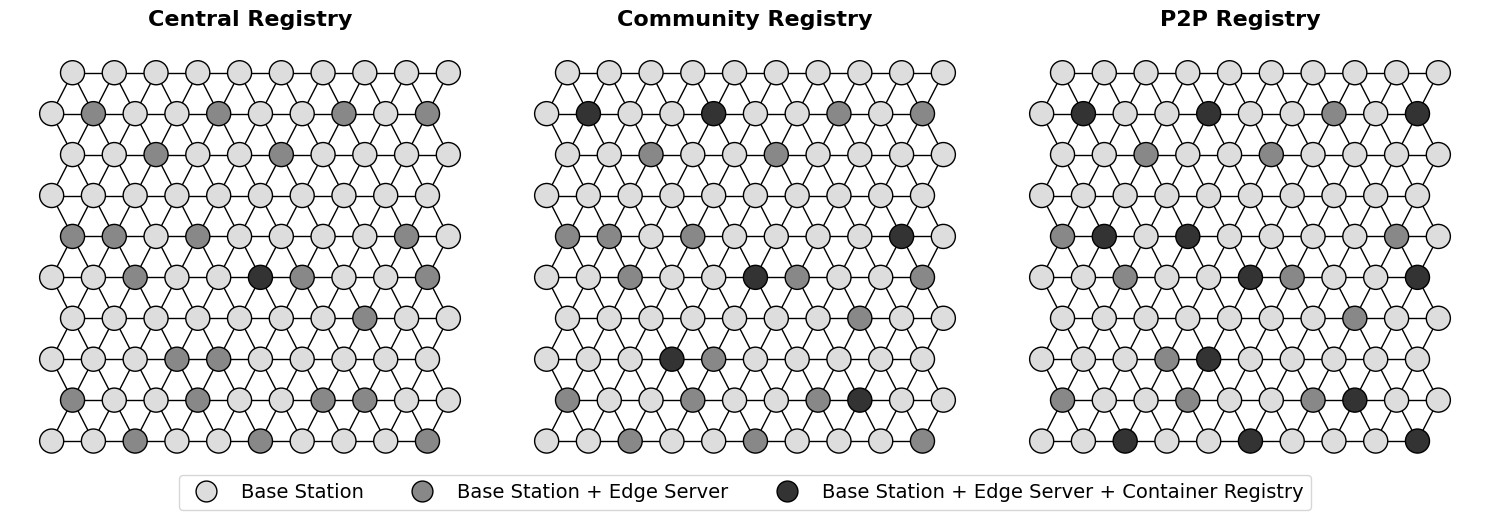

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, dataset in enumerate(datasets):
    # Creating a Simulator object
    simulator = edge_sim_py.Simulator()

    # Loading the dataset
    simulator.initialize(input_file=dataset)

    # Getting positions and colors
    positions, colors = display_topology(simulator.topology)
    
    # Drawing the topology
    nx.draw(
        simulator.topology,
        pos=positions,
        font_weight="bold",
        font_color="whitesmoke",
        node_color=colors,
        linewidths=1,
        edgecolors="black",
        ax=axs[i]
    )

    # Setting the title
    axs[i].set_title(titles[i], fontsize=16, fontweight="bold")


# Legend
bs_line = mlines.Line2D([], [], marker="o", markersize=15, label="Base Station", linewidth=0, markerfacecolor="#dddddd", markeredgecolor="black", markeredgewidth=1)
es_line = mlines.Line2D([], [], marker="o", markersize=15, label="Base Station + Edge Server", linewidth=0, markerfacecolor="#888888", markeredgecolor="black", markeredgewidth=1)
cr_line = mlines.Line2D([], [], marker="o", markersize=15, label="Base Station + Edge Server + Container Registry", linewidth=0, markerfacecolor="#333333", markeredgecolor="black", markeredgewidth=1)

fig.legend(
    handles=[bs_line, es_line, cr_line],
    loc="lower center",
    ncols=3,
    fontsize=14,
    bbox_to_anchor=(0.5, -0.05),
)

plt.tight_layout()
plt.savefig("logs/topologies.pdf", bbox_inches="tight")
plt.savefig("logs/topologies.svg", bbox_inches="tight")
plt.show()

## Base functions

#### Latency

In [4]:
def get_latency():
    user_data = []

    for seed in seeds:
        for log in logs:
            simulation_data = {
                "seed": seed,
                "dataset": log,
                "minimal": 0,
                "recommended": 0,
            }

            for requirement in requirements:
                # Opening file
                user_msgpack_file = f"{parent_dir}/algorithm={log[0]};dataset={log[1]}_{requirement};seed={seed}/User.msgpack"
                user_file = open(user_msgpack_file, "rb")
                user_msgpack = msgpack.load(user_file)
                user_df = pd.DataFrame(user_msgpack)

                # Collecting information
                latency = user_df[["Object", "Delays"]]

                # Persisting information
                simulation_data[requirement] = latency["Delays"].mean()

                # Closing file
                user_file.close()

            # Appending data
            user_data.append(simulation_data)

    return pd.DataFrame(user_data)

In [5]:
# Function to determine the server type based on CPU and RAM
def get_server_type(cpu, memory):
    for server_type, specs in edge_server_specs.items():
        if cpu == specs['cpu'] and memory == specs['memory']:
            return server_type
    return None

# Load the new EdgeServer msgpack file
def load_msgpack(file_path):
    with open(file_path, 'rb') as f:
        return msgpack.unpack(f, raw=False)


def get_usage():
    edge_server_data = []

    edge_server_specs = {
        "sgi": {"cpu": 32, "memory": 32768, "disk": 131072},
        "hpe": {"cpu": 48, "memory": 65536, "disk": 131072},
        "acer": {"cpu": 36, "memory": 65536, "disk": 131072},
        "raspberry_pi_5": {"cpu": 4, "memory": 8192, "disk": 131072}
    }

    for seed in seeds:
        for log in logs:
            simulation_date = {
                "seed": seed,
                "dataset": log,
                "minimal": 0,
                "recommended": 0,
            }
            
            for requirement in requirements:
                # Opening file
                edge_server_msgpack_file = f"{parent_dir}/algorithm={log[0]};dataset={log[1]}_{requirement};seed={seed}/EdgeServer.msgpack"
                edge_server = load_msgpack(edge_server_msgpack_file)
                edge_server_df = pd.DataFrame(edge_server)
                
                # Add a column to identify the type of edge server
                edge_server_df['Server Type'] = edge_server_df.apply(lambda row: get_server_type(row['CPU'], row['RAM']), axis=1)


                #  Determine if the server is in use based on CPU, RAM, and Disk demands
                edge_server_df['In Use'] = (
                    (edge_server_df['CPU Demand'] > 0) &
                    (edge_server_df['RAM Demand'] > 0) &
                    (edge_server_df['Disk Demand'] > 0)
                )
                
                # Collecting information
                # Calculate the total usage duration for each server type
                usage_by_server_type = edge_server_df[edge_server_df['In Use']].groupby('Server Type')['Time Step'].agg(['min', 'max', 'count'])
                usage_by_server_type['Duration'] = usage_by_server_type['max'] - usage_by_server_type['min']


                # Persisting information
                simulation_date[requirement] = usage_by_server_type

                # print(simulation_date[requirement])

            edge_server_data.append(simulation_date)
            # print("appended")
            # print(edge_server_data)
    
    return pd.DataFrame(edge_server_data)

In [6]:
msgpack_file = f"logs/algorithm=p2p_enhanced;dataset=p2p_minimal;seed=1/EdgeServer.msgpack"
file = open(msgpack_file, "rb")
msgpack_data = msgpack.load(file)
df = pd.DataFrame(msgpack_data)
print(df)
df.to_csv("logs/edge_server.csv", index=False)

              Object  Time Step  Instance ID Coordinates  Available  CPU  \
0       EdgeServer_1          0            1     [13, 1]       True   32   
1       EdgeServer_2          0            2      [4, 4]       True   32   
2       EdgeServer_3          0            3     [14, 8]       True   32   
3       EdgeServer_4          0            4     [18, 4]       True   32   
4       EdgeServer_5          0            5     [11, 7]       True   32   
...              ...        ...          ...         ...        ...  ...   
86419  EdgeServer_20       3600           20      [6, 2]       True    4   
86420  EdgeServer_21       3600           21      [5, 7]       True    4   
86421  EdgeServer_22       3600           22      [7, 1]       True    4   
86422  EdgeServer_23       3600           23     [17, 5]       True    4   
86423  EdgeServer_24       3600           24     [12, 4]       True    4   

         RAM    Disk  CPU Demand  RAM Demand  Disk Demand  
0      32768  131072       

In [7]:
import pandas as pd

# Define the specifications of the edge servers
edge_server_specs = {
    "sgi": {"cpu": 32, "memory": 32768, "disk": 131072},
    "hpe": {"cpu": 48, "memory": 65536, "disk": 131072},
    "acer": {"cpu": 36, "memory": 65536, "disk": 131072},
    "raspberry_pi_5": {"cpu": 4, "memory": 8192, "disk": 131072}
}

# Function to determine the server type based on CPU and RAM
def get_server_type(cpu, memory):
    for server_type, specs in edge_server_specs.items():
        if cpu == specs['cpu'] and memory == specs['memory']:
            return server_type
    return None

# Load the new EdgeServer msgpack file
def load_msgpack(file_path):
    with open(file_path, 'rb') as f:
        return msgpack.unpack(f, raw=False)

edge_server_central = load_msgpack('logs/algorithm=p2p_enhanced;dataset=p2p_minimal;seed=1/EdgeServer.msgpack')
edge_server_central_df = pd.DataFrame(edge_server_central)

# Add a column to identify the type of edge server
edge_server_central_df['Server Type'] = edge_server_central_df.apply(lambda row: get_server_type(row['CPU'], row['RAM']), axis=1)

# Determine if the server is in use based on CPU, RAM, and Disk demands
edge_server_central_df['In Use'] = (
    (edge_server_central_df['CPU Demand'] > 0) &
    (edge_server_central_df['RAM Demand'] > 0) &
    (edge_server_central_df['Disk Demand'] > 0)
)

print(edge_server_central_df[['CPU', 'RAM', 'Server Type', 'In Use']].head(10))

# Calculate the total usage duration for each server type
usage_by_server_type = edge_server_central_df[edge_server_central_df['In Use']].groupby('Server Type')['Time Step'].agg(['min', 'max', 'count'])
usage_by_server_type['Duration'] = usage_by_server_type['max'] - usage_by_server_type['min']

# Display the result
# import ace_tools as tools; tools.display_dataframe_to_user(name="Edge Server Usage by Type", dataframe=usage_by_server_type)
print(usage_by_server_type)


   CPU    RAM Server Type  In Use
0   32  32768         sgi    True
1   32  32768         sgi    True
2   32  32768         sgi    True
3   32  32768         sgi    True
4   32  32768         sgi    True
5   32  32768         sgi    True
6   48  65536         hpe    True
7   48  65536         hpe    True
8   48  65536         hpe    True
9   48  65536         hpe    True
                min   max  count  Duration
Server Type                               
acer              0  3600  19454      3600
hpe               0  3600  21214      3600
raspberry_pi_5    0  3600  14215      3600
sgi               0  3600  21494      3600


In [8]:
usage_by_server_type.keys()

Index(['min', 'max', 'count', 'Duration'], dtype='object')

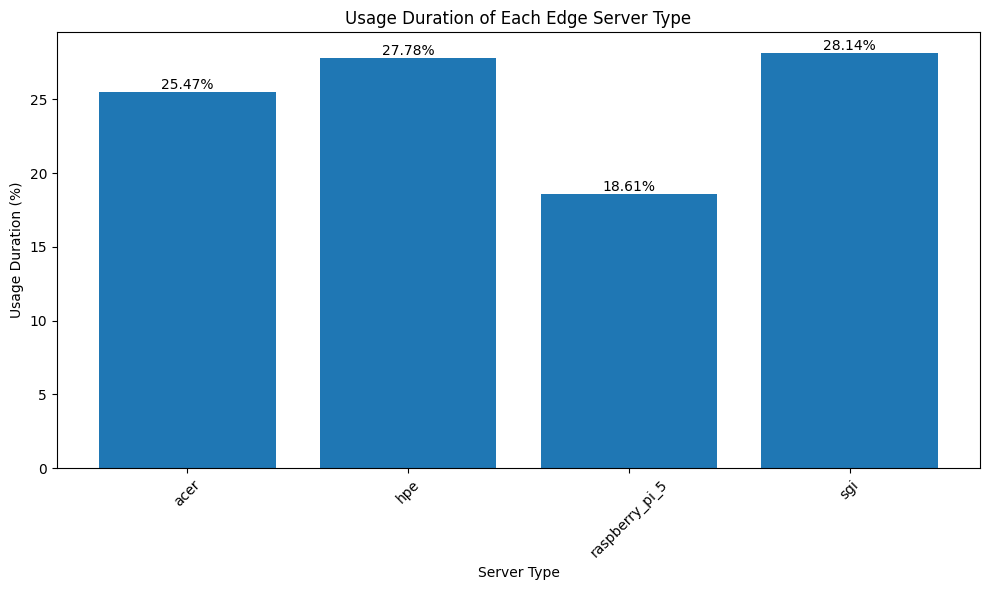

In [9]:
# Extract the relevant data for plotting
server_types = usage_by_server_type.index
count = (usage_by_server_type['count'] / usage_by_server_type['count'].sum()) * 100

# Plot the usage durations for each server type
plt.figure(figsize=(10, 6))
bars = plt.bar(server_types, count)
plt.xlabel('Server Type')
plt.ylabel('Usage Duration (%)')
plt.title('Usage Duration of Each Edge Server Type')
plt.xticks(rotation=45)
plt.tight_layout()
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')

plt.show()

#### Service Reallocations

In [10]:
def get_reallocations_data(step):
    service_data = []

    for seed in seeds:
        for log in logs:
            simulation_data = {
                "seed": seed,
                "dataset": log,
                "minimal (total)": 0,
                "minimal (w/o cache)": 0,
                "recommended (total)": 0,
                "recommended (w/o cache)": 0,
            }

            for requirement in requirements:
                # Opening file
                service_msgpack_file = f"{parent_dir}/algorithm={log[0]};dataset={log[1]}_{requirement};seed={seed}/Service.msgpack"
                service_file = open(service_msgpack_file, "rb")
                service_msgpack = msgpack.load(service_file)
                service_df = pd.DataFrame(service_msgpack)

                # Collecting information
                migrations_last_step = service_df[service_df["Time Step"] == step][["Object", "Number of Finished Migrations", "Number of Finished Migrations Without Using Cache"]]

                # Persisting information
                simulation_data[f"{requirement} (total)"] = migrations_last_step["Number of Finished Migrations"].sum()
                simulation_data[f"{requirement} (w/o cache)"] = migrations_last_step["Number of Finished Migrations Without Using Cache"].sum()

                # Closing file
                service_file.close()

            # Appending data
            service_data.append(simulation_data)

    return pd.DataFrame(service_data)

#### Registry Usage

In [11]:
def get_registry_usage():
    registry_data = []

    for seed in seeds:
        for log in logs:
            simulation_data = {
                "seed": seed,
                "dataset": log,
                "minimal": 0,
                "recommended": 0,
            }

            for requirement in requirements:
                # Opening file
                registry_msgpack_file = f"{parent_dir}/algorithm={log[0]};dataset={log[1]}_{requirement};seed={seed}/ContainerRegistry.msgpack"
                registry_file = open(registry_msgpack_file, "rb")
                registry_msgpack = msgpack.load(registry_file)
                registry_df = pd.DataFrame(registry_msgpack)

                # Collecting information
                registry_filtered_data = (
                    registry_df[registry_df["P2P"] == True][["Object", "Provisioning", "Not Provisioning"]]
                    if log[1] == "p2p"
                    else registry_df[["Object", "Provisioning", "Not Provisioning"]]
                )
                registry_data_grouped = registry_filtered_data.groupby("Object").sum()
                registry_data_grouped["Total Steps"] = registry_data_grouped.sum(axis=1)
                registry_data_grouped["Provisioning Percentage"] = registry_data_grouped["Provisioning"] / registry_data_grouped["Total Steps"]
                registry_data_grouped["Not Provisioning Percentage"] = registry_data_grouped["Not Provisioning"] / registry_data_grouped["Total Steps"]

                # Persisting information
                simulation_data[requirement] = registry_data_grouped["Provisioning Percentage"].mean()

                # Closing file
                registry_file.close()

            # Appending data
            registry_data.append(simulation_data)

    return pd.DataFrame(registry_data)

#### Number of Registries over Time

In [12]:
def get_number_of_registries(seed, requirement):
    registry_data = {}

    for log in logs:
        # Opening file
        registry_msgpack_file = f"{parent_dir}/algorithm={log[0]};dataset={log[1]}_{requirement};seed={seed}/ContainerRegistry.msgpack"
        registry_file = open(registry_msgpack_file, "rb")
        registry_msgpack = msgpack.load(registry_file)
        registry_df = pd.DataFrame(registry_msgpack)

        # Collecting information
        registries_per_timestep = registry_df[registry_df["Time Step"] > 0].groupby(["Time Step"]).count()["Object"]

        # Persisting information
        registry_data[log[0].capitalize()] = registries_per_timestep

        # Closing file
        registry_file.close()

    registries_per_timestep_df = pd.concat(registry_data, axis=1)

    return registries_per_timestep_df

#### Plot Data

In [13]:
def calculate_x(x, width, i, n):
    return x + width * (i - n / 2) + width / 2


def plot_data_with_grouped_bar(
    keys: list,
    mean_df: pd.DataFrame,
    std_df: pd.DataFrame,
    xlabel: str,
    ylabel: str,
    filename: str,
    bbox_to_anchor: tuple,
    yscale: str = "linear",
    yticks: list = None,
):
    # Plotting bar chart
    fig, ax = plt.subplots(figsize=(10, 6))

    width = 0.8

    hatches = ["", "/", "|", "\\"]

    x = np.arange(len(mean_df))

    for key in keys:
        ax.bar(
            x=calculate_x(x, width/len(keys), keys.index(key), len(keys)),
            height=mean_df[key],
            width=width/len(keys),
            label=key.title(),
            yerr=std_df[key],
            hatch=hatches.pop(0),
            color="#aaaaaa",
            edgecolor="black",
            linewidth=2,
            error_kw={"elinewidth": 2, "capthick": 2, "capsize": 5}
        )

    # Setting labels and ticks
    ax.legend(fontsize=20, bbox_to_anchor=bbox_to_anchor, loc="upper center", ncol=2)
    ax.set_xlabel(xlabel, fontsize=24, fontweight="bold", labelpad=10)
    ax.set_ylabel(ylabel, fontsize=24, fontweight="bold", labelpad=10, loc="center")
    ax.set_xticks(x, labels)
    ax.tick_params(axis="x", labelsize=24)
    ax.tick_params(axis="y", labelsize=24)
    ax.set_yscale(yscale)
    if yscale == "log":
        ax.set_yticks(yticks)
        ax.get_yaxis().set_major_formatter(mtick.ScalarFormatter())
    if ylabel == "% of Steps Active":
        ax.get_yaxis().set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

    # Saving figure
    plt.tight_layout()
    plt.savefig(f"{filename}.pdf", bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")
    plt.show()

In [14]:
def plot_registries_over_time(
    labels: list,
    data: pd.DataFrame,
    xlabel: str,
    ylabel: str,
    filename: str,
    bbox_to_anchor,
):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.set_xlabel(xlabel, fontsize=24, fontweight="bold", labelpad=10)
    ax.set_ylabel(ylabel, fontsize=24, fontweight="bold", labelpad=10, loc="center")
    ax.tick_params(axis="x", labelsize=24)
    ax.tick_params(axis="y", labelsize=24)

    p = ax.plot(
        data,
        linewidth=2,
    )

    # Setting line styles and colors
    p[0].set_linestyle((0, (1, 10))) # loosely dotted
    p[0].set_color("black")
    p[1].set_linestyle((0, (5, 5))) # dashed
    p[1].set_color("black")
    p[2].set_color("black") 

    # Adding legend
    ax.legend(labels, fontsize=20, bbox_to_anchor=bbox_to_anchor, loc="upper center", ncol=3)

    # Saving figure
    plt.tight_layout()
    plt.savefig(f"{filename}.pdf", bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")
    plt.show()

## Results

In [15]:
parent_dir = "logs"

LAST_STEP = 3600

logs = [
    ("central", "central"),
    ("community", "community"),
    ("p2p", "p2p"),
]

seeds = [1, 2, 3, 4, 5]

requirements = ["minimal", "recommended"]

label = ["Central", "Community", "P2P", "P2P Enhanced"]

In [16]:
usage = get_usage()
print(usage)

    seed                 dataset  \
0      1      (central, central)   
1      1  (community, community)   
2      1              (p2p, p2p)   
3      2      (central, central)   
4      2  (community, community)   
5      2              (p2p, p2p)   
6      3      (central, central)   
7      3  (community, community)   
8      3              (p2p, p2p)   
9      4      (central, central)   
10     4  (community, community)   
11     4              (p2p, p2p)   
12     5      (central, central)   
13     5  (community, community)   
14     5              (p2p, p2p)   

                                              minimal  \
0                   min   max  count  Duration
Ser...   
1                   min   max  count  Duration
Ser...   
2                   min   max  count  Duration
Ser...   
3                   min   max  count  Duration
Ser...   
4                   min   max  count  Duration
Ser...   
5                   min   max  count  Duration
Ser...   
6                   min 

In [17]:
# usage.to_csv("logs/edge_server_usage.csv", index=True)

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import msgpack
import os

# Define the edge server specifications
edge_server_specs = {
    "sgi": {"cpu": 32, "memory": 32768, "disk": 131072},
    "hpe": {"cpu": 48, "memory": 65536, "disk": 131072},
    "acer": {"cpu": 36, "memory": 65536, "disk": 131072},
    "raspberry_pi_5": {"cpu": 4, "memory": 8192, "disk": 131072}
}

# Function to determine the server type based on CPU and RAM
def get_server_type(cpu, memory):
    for server_type, specs in edge_server_specs.items():
        if cpu == specs['cpu'] and memory == specs['memory']:
            return server_type
    return None

# Load the msgpack file
def load_msgpack(file_path):
    with open(file_path, 'rb') as f:
        return msgpack.unpack(f, raw=False)

# Compute the usage data
def get_usage(parent_dir, logs, seeds, requirements):
    edge_server_data = []

    for seed in seeds:
        for log in logs:
            simulation_data = {
                "seed": seed,
                "strategy": log[0],
                "dataset": log[1],
                "minimal": None,
                "recommended": None,
            }
            
            for requirement in requirements:
                # Opening file
                edge_server_msgpack_file = os.path.join(parent_dir, f"algorithm={log[0]};dataset={log[1]}_{requirement};seed={seed}/EdgeServer.msgpack")
                edge_server = load_msgpack(edge_server_msgpack_file)
                edge_server_df = pd.DataFrame(edge_server)
                
                # Add a column to identify the type of edge server
                edge_server_df['Server Type'] = edge_server_df.apply(lambda row: get_server_type(row['CPU'], row['RAM']), axis=1)

                # Determine if the server is in use based on CPU, RAM, and Disk demands
                edge_server_df['In Use'] = (
                    (edge_server_df['CPU Demand'] > 0) &
                    (edge_server_df['RAM Demand'] > 0) &
                    (edge_server_df['Disk Demand'] > 0)
                )
                
                # Calculate the total usage duration for each server type
                usage_by_server_type = edge_server_df[edge_server_df['In Use']].groupby('Server Type')['Time Step'].agg(['min', 'max', 'count'])
                usage_by_server_type['Duration'] = usage_by_server_type['max'] - usage_by_server_type['min']

                # Ensure numeric types for aggregation
                usage_by_server_type = usage_by_server_type.apply(pd.to_numeric, errors='coerce')

                # Persisting information
                server_types = usage_by_server_type.index
                count = (usage_by_server_type['count'] / usage_by_server_type['count'].sum()) * 100
                
                simulation_data[requirement] = [{
                    "server_type": server_type,
                    "count": count[server_type]
                } for server_type in server_types]

                # print(simulation_data)
            edge_server_data.append(simulation_data)
    
    return pd.DataFrame(edge_server_data)

# Parameters
parent_dir = "logs"
logs = [
    ("central", "central"), 
    ("community", "community"), 
    ("p2p", "p2p")
]
seeds = [1, 2, 3, 4, 5]
requirements = ["minimal", "recommended"]
labels = ["Central", "Community", "P2P"]

# Get the usage data
usage_data = get_usage(parent_dir, logs, seeds, requirements)
usage_data.to_csv("usage_data.csv")

print(usage_data)

# Ensure all durations are numeric for aggregation
usage_data['minimal'] = usage_data['minimal'].apply(pd.to_numeric, errors='coerce')
usage_data['recommended'] = usage_data['recommended'].apply(pd.to_numeric, errors='coerce')

# Calculate mean and std usage for each strategy and server type
mean_usage = usage_data.groupby(['strategy', 'dataset']).agg(['mean', 'std'])

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(labels))
width = 0.35  # Width of the bars

for i, req in enumerate(requirements):
    means = [mean_usage.loc[(log[0], log[1])][(req, 'mean')] for log in logs]
    stds = [mean_usage.loc[(log[0], log[1])][(req, 'std')] for log in logs]
    ax.bar([p + width * i for p in x], means, width, yerr=stds, label=req.capitalize())

ax.set_xlabel('Registry Provisioning Strategy')
ax.set_ylabel('Mean Usage Duration')
ax.set_title('Mean Usage Duration of Each Edge Server Type')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

plt.show()


    seed   strategy    dataset  \
0      1    central    central   
1      1  community  community   
2      1        p2p        p2p   
3      2    central    central   
4      2  community  community   
5      2        p2p        p2p   
6      3    central    central   
7      3  community  community   
8      3        p2p        p2p   
9      4    central    central   
10     4  community  community   
11     4        p2p        p2p   
12     5    central    central   
13     5  community  community   
14     5        p2p        p2p   

                                              minimal  \
0   [{'server_type': 'acer', 'count': 25.041857567...   
1   [{'server_type': 'acer', 'count': 24.307539277...   
2   [{'server_type': 'acer', 'count': 24.990741169...   
3   [{'server_type': 'acer', 'count': 24.981701555...   
4   [{'server_type': 'acer', 'count': 24.127551020...   
5   [{'server_type': 'acer', 'count': 24.948179028...   
6   [{'server_type': 'acer', 'count': 25.810551400...   

ValueError: setting an array element with a sequence.

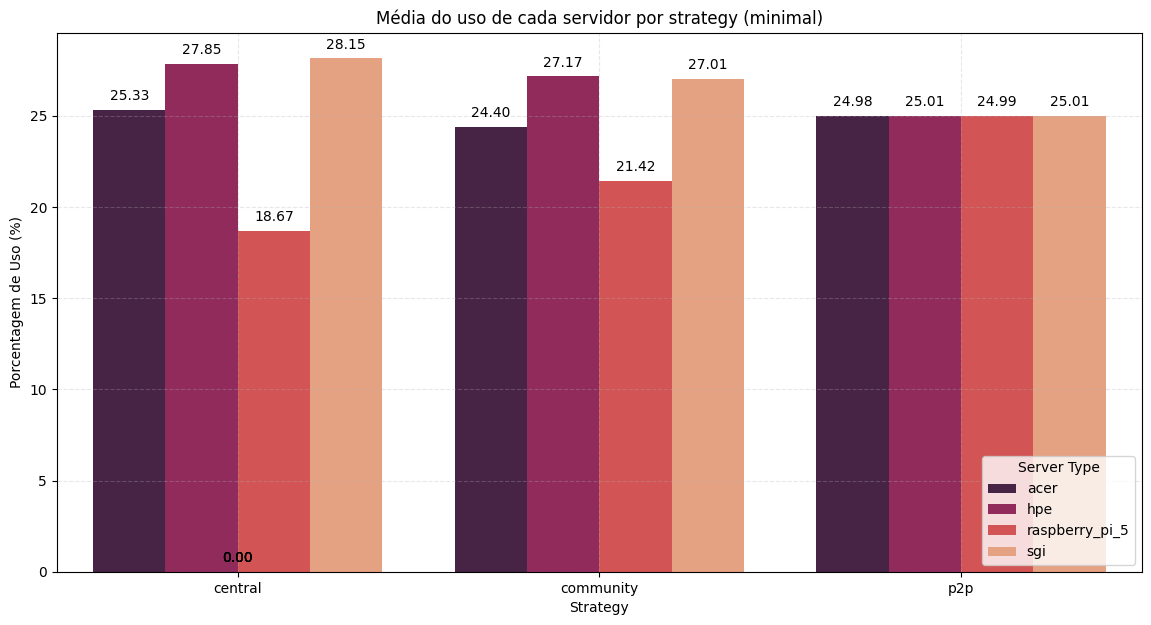

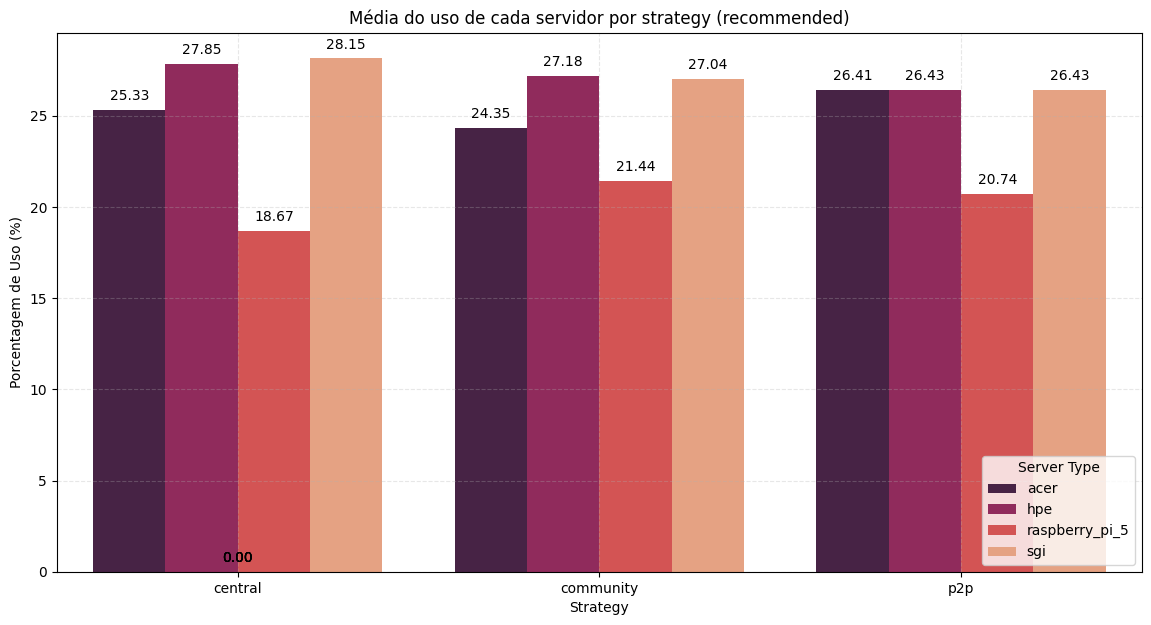

In [53]:
import json
# Função para normalizar listas de dicionários dentro de uma coluna
def normalize_column(df, col):
    normalized_df = pd.json_normalize(df[col].apply(json.loads))
    normalized_df.columns = [f"{col}_{sub_col}" for sub_col in normalized_df.columns]
    return normalized_df

def add_labels(data, ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


# Carregar os dados
file_path = 'usage_data.csv'
data = pd.read_csv(file_path)

# Normalizar as colunas 'minimal' e 'recommended'
data['minimal'] = data['minimal'].apply(eval)
data['recommended'] = data['recommended'].apply(eval)

minimal_df = data.explode('minimal').reset_index(drop=True)
recommended_df = data.explode('recommended').reset_index(drop=True)

# Expandir as colunas JSON em colunas separadas
minimal_expanded = pd.json_normalize(minimal_df['minimal'])
recommended_expanded = pd.json_normalize(recommended_df['recommended'])

# Adicionar de volta as colunas principais ao dataframe expandido
minimal_expanded = pd.concat([minimal_df[['seed', 'strategy', 'dataset']], minimal_expanded], axis=1)
recommended_expanded = pd.concat([recommended_df[['seed', 'strategy', 'dataset']], recommended_expanded], axis=1)

# Calcular a média do atributo 'count' para cada 'server_type' por 'strategy' e 'dataset'
minimal_stats = minimal_expanded.groupby(['strategy', 'dataset', 'server_type']).agg({'count': ['mean', 'std']}).reset_index()
recommended_stats = recommended_expanded.groupby(['strategy', 'dataset', 'server_type']).agg({'count': ['mean', 'std']}).reset_index()

# Renaming columns for easier access
minimal_stats.columns = ['strategy', 'dataset', 'server_type', 'count_mean', 'count_std']
recommended_stats.columns = ['strategy', 'dataset', 'server_type', 'count_mean', 'count_std']


import matplotlib.pyplot as plt
import seaborn as sns

custom_pallete = sns.color_palette("rocket", 4)

# Plotando os dados minimal
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=minimal_stats, x='strategy', y='count_mean', hue='server_type', palette=custom_pallete)
# for i in range(len(minimal_stats)):
#     plt.errorbar(x=i, y=minimal_stats['count_mean'][i], yerr=minimal_stats['count_std'][i], fmt='none', c='black')
add_labels(minimal_avg, ax)
plt.title('Média do uso de cada servidor por strategy (minimal)')
plt.ylabel('Porcentagem de Uso (%)')
plt.xlabel('Strategy')
plt.legend(title='Server Type', loc="lower right")
plt.grid(True, alpha=0.3, which='both', linestyle='--')
plt.show()

# Plotando os dados recommended
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=recommended_stats, x='strategy', y='count_mean', hue='server_type', palette=custom_pallete)
# for i in range(len(recommended_stats)):
#     plt.errorbar(x=i, y=minimal_stats['count_mean'][i], yerr=recommended_stats['count_std'][i], fmt='none', c='black')
add_labels(recommended_avg, ax)
plt.title('Média do uso de cada servidor por strategy (recommended)')
plt.ylabel('Porcentagem de Uso (%)')
plt.xlabel('Strategy')
plt.legend(title='Server Type', loc="lower right")
plt.grid(True, alpha=0.3, which='both', linestyle='--')
plt.show()

### Base Comparison

In [ ]:
parent_dir = "logs"

LAST_STEP = 3600

logs = [
    ("central", "central"),
    ("community", "community"),
    ("p2p", "p2p"),
    
]

seeds = [1, 2, 3, 4, 5]

requirements = ["minimal", "recommended"]

labels = ["Central", "Community", "P2P"]

#### User latency

In [ ]:
# Getting latency data
latency_df = get_latency()

# Calculating mean values and standard deviations
latency_mean_df = latency_df.groupby(["dataset"]).mean()
latency_std_df = latency_df.groupby(["dataset"]).std()

In [ ]:
latency_df

,seed,dataset,minimal,recommended
0,1,"(central, central)",15.267441,14.896749
1,1,"(community, community)",12.632178,13.024661
2,1,"(p2p, p2p)",15.356112,17.192331
3,2,"(central, central)",14.794463,15.465997
4,2,"(community, community)",13.074609,13.270002
5,2,"(p2p, p2p)",15.834220,17.845506
6,3,"(central, central)",15.351407,15.110386
7,3,"(community, community)",12.772648,13.068091
8,3,"(p2p, p2p)",15.467193,17.092976
9,4,"(central, central)",14.853281,14.679256


In [ ]:
latency_mean_df

,seed,minimal,recommended
dataset,,,
"(central, central)",3.0,15.145284,15.216414
"(community, community)",3.0,12.781635,13.022717
"(p2p, p2p)",3.0,15.476959,17.120067


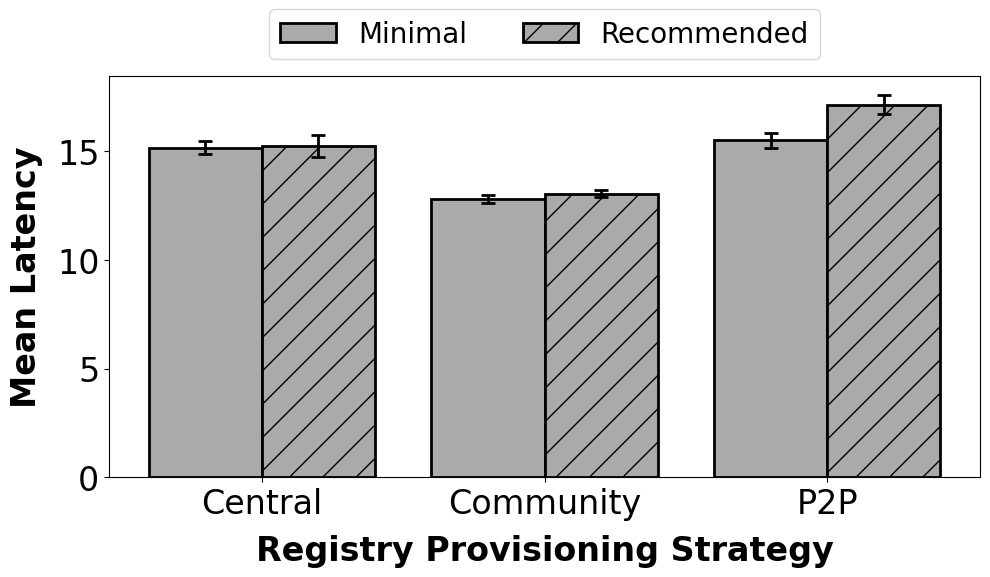

In [ ]:
plot_data_with_grouped_bar(
    ["minimal", "recommended"],
    latency_mean_df,
    latency_std_df,
    "Registry Provisioning Strategy",
    "Mean Latency",
    "logs/app_mean_latency_grouped",
    (0.5, 1.2)
)

#### Service reallocations

In [ ]:
# Getting reallocations data
reallocations_df = get_reallocations_data(LAST_STEP)

# Calculating mean values and standard deviations
reallocations_mean_df = reallocations_df.groupby(["dataset"]).mean()
reallocations_std_df = reallocations_df.groupby(["dataset"]).std()

In [ ]:
reallocations_df

,seed,dataset,minimal (total),minimal (w/o cache),recommended (total),recommended (w/o cache)
0,1,"(central, central)",2893,758,2937,768
1,1,"(community, community)",3070,644,3074,646
2,1,"(p2p, p2p)",2831,677,2868,754
3,2,"(central, central)",2828,756,2827,775
4,2,"(community, community)",2995,645,2959,647
5,2,"(p2p, p2p)",2610,674,2584,735
6,3,"(central, central)",2834,742,2847,759
7,3,"(community, community)",3057,642,3089,649
8,3,"(p2p, p2p)",2734,686,2615,752
9,4,"(central, central)",2812,744,2905,737


In [ ]:
reallocations_mean_df

,seed,minimal (total),minimal (w/o cache),recommended (total),recommended (w/o cache)
dataset,,,,,
"(central, central)",3.0,2849.6,751.0,2875.0,761.8
"(community, community)",3.0,3074.8,641.6,3041.4,646.2
"(p2p, p2p)",3.0,2742.4,676.0,2704.6,742.8


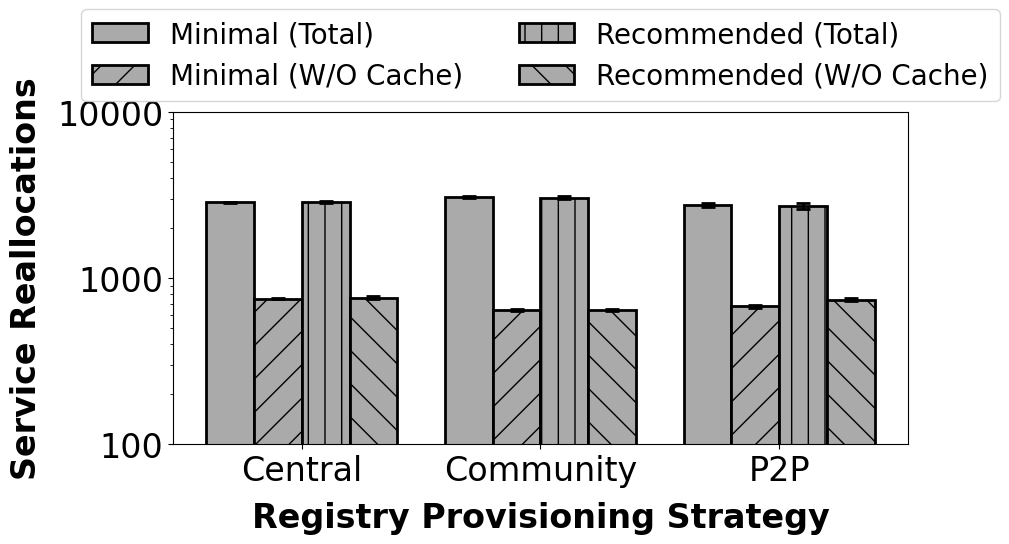

In [ ]:
plot_data_with_grouped_bar(
    [
        "minimal (total)",
        "minimal (w/o cache)",
        "recommended (total)",
        "recommended (w/o cache)",
    ],
    reallocations_mean_df,
    reallocations_std_df,
    "Registry Provisioning Strategy",
    "Service Reallocations",
    "logs/service_reallocations_grouped",
    (0.5, 1.35),
    "log",
    [100, 1000, 10000]
)

#### Registry Usage

In [ ]:
# Getting reallocations data
registry_usage_df = get_registry_usage()

# Calculating mean values and standard deviations
registry_usage_mean_df = registry_usage_df.groupby(["dataset"]).mean()
registry_usage_std_df = registry_usage_df.groupby(["dataset"]).std()

In [ ]:
registry_usage_df

,seed,dataset,minimal,recommended
0,1,"(central, central)",0.703416,0.705082
1,1,"(community, community)",0.225169,0.219430
2,1,"(p2p, p2p)",0.056671,0.084019
3,2,"(central, central)",0.639267,0.680089
4,2,"(community, community)",0.220217,0.222438
5,2,"(p2p, p2p)",0.054483,0.085032
6,3,"(central, central)",0.654540,0.698139
7,3,"(community, community)",0.222022,0.232482
8,3,"(p2p, p2p)",0.056842,0.084548
9,4,"(central, central)",0.699806,0.660928


In [ ]:
registry_usage_mean_df

,seed,minimal,recommended
dataset,,,
"(central, central)",3.0,0.682588,0.688753
"(community, community)",3.0,0.224290,0.226567
"(p2p, p2p)",3.0,0.056201,0.083325


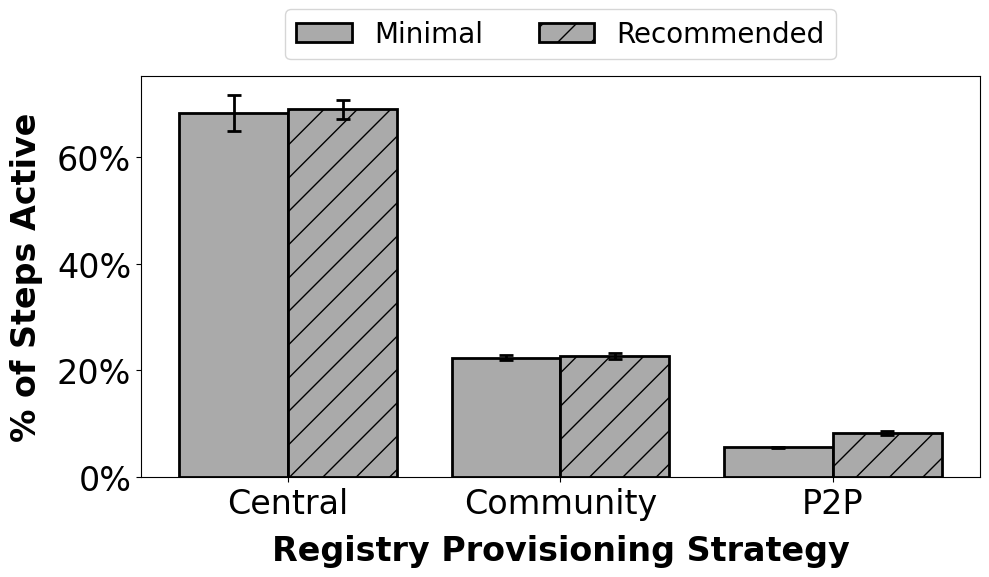

In [ ]:
plot_data_with_grouped_bar(
    ["minimal", "recommended"],
    registry_usage_mean_df,
    registry_usage_std_df,
    "Registry Provisioning Strategy",
    "% of Steps Active",
    "logs/registry_usage_grouped",
    (0.5, 1.2),
)

#### Number of registries

In [ ]:
seed = 1
requirement = "minimal"

registry_df = get_number_of_registries(seed, requirement)

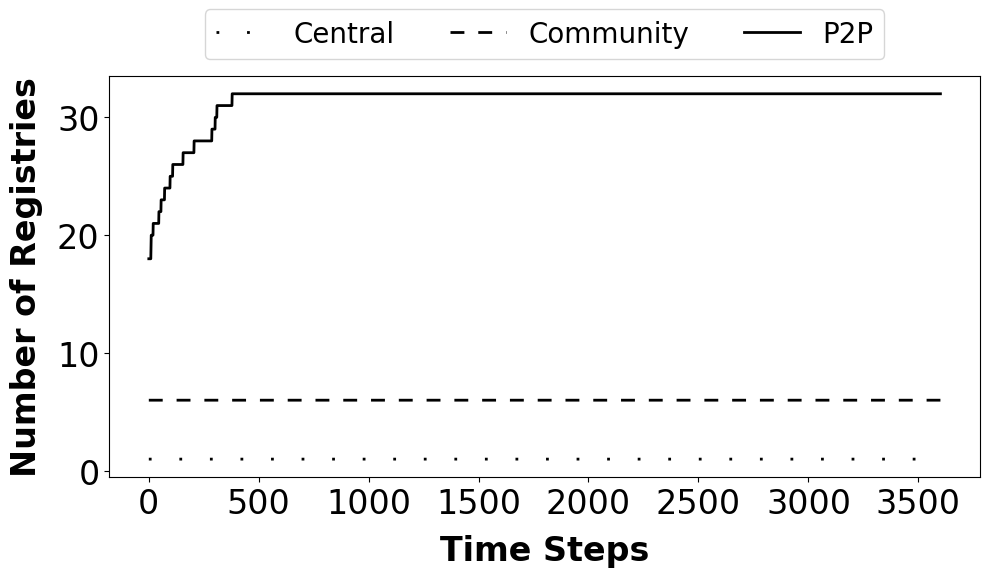

In [ ]:
plot_registries_over_time(
    labels,
    registry_df,
    "Time Steps",
    "Number of Registries",
    "logs/number_of_registries_over_time",
    (0.5, 1.2)
)

### P2P-based variation comparison

In [ ]:
logs = [
    ("community", "community"),
    ("p2p", "p2p"),
    ("p2p_enhanced", "p2p")
]

labels = ["Community", "P2P", "Dynamic"]

#### User latency

In [ ]:
# Getting data transferred data
latency_df_2 = get_latency()

# Calculating mean values and standard deviations
latency_mean_df_2 = latency_df_2.groupby(["dataset"]).mean()
latency_std_df_2 = latency_df_2.groupby(["dataset"]).std()

In [ ]:
latency_df_2

,seed,dataset,minimal,recommended
0,1,"(community, community)",12.632178,13.024661
1,1,"(p2p, p2p)",15.356112,17.192331
2,1,"(p2p_enhanced, p2p)",14.533964,14.554522
3,2,"(community, community)",13.074609,13.270002
4,2,"(p2p, p2p)",15.834220,17.845506
5,2,"(p2p_enhanced, p2p)",14.735529,14.895052
6,3,"(community, community)",12.772648,13.068091
7,3,"(p2p, p2p)",15.467193,17.092976
8,3,"(p2p_enhanced, p2p)",14.832145,15.107069
9,4,"(community, community)",12.715719,12.889977


In [ ]:
latency_mean_df_2

,seed,minimal,recommended
dataset,,,
"(community, community)",3.0,12.781635,13.022717
"(p2p, p2p)",3.0,15.476959,17.120067
"(p2p_enhanced, p2p)",3.0,14.616873,14.742980


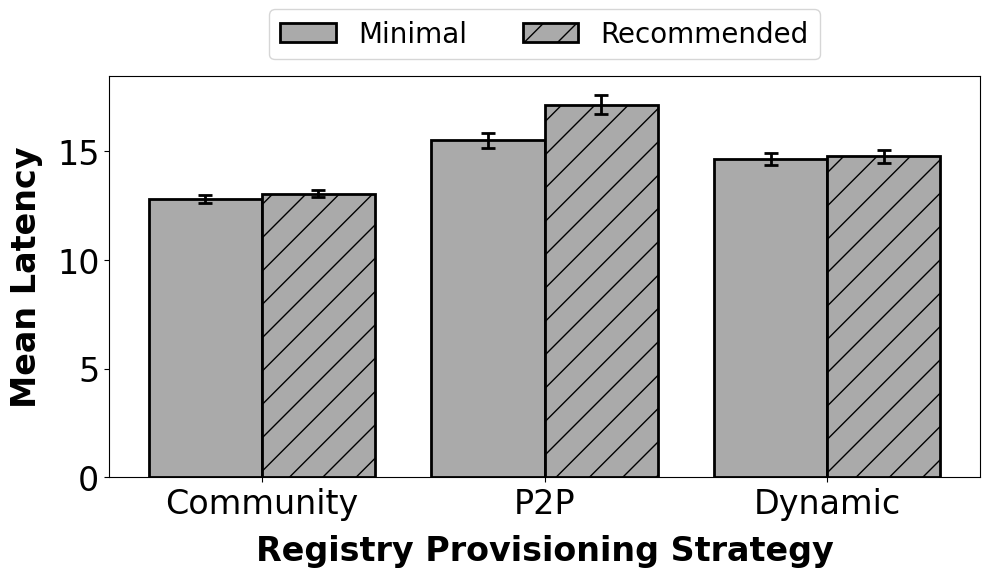

In [ ]:
plot_data_with_grouped_bar(
    ["minimal", "recommended"],
    latency_mean_df_2,
    latency_std_df_2,
    "Registry Provisioning Strategy",
    "Mean Latency",
    "logs/app_mean_latency_grouped_2",
    (0.5, 1.2)
)

#### Service reallocations

In [ ]:
# Getting reallocations data
reallocations_df_2 = get_reallocations_data(LAST_STEP)

# Calculating mean values and standard deviations
reallocations_mean_df_2 = reallocations_df_2.groupby(["dataset"]).mean()
reallocations_std_df_2 = reallocations_df_2.groupby(["dataset"]).std()

In [ ]:
reallocations_df_2

,seed,dataset,minimal (total),minimal (w/o cache),recommended (total),recommended (w/o cache)
0,1,"(community, community)",3070,644,3074,646
1,1,"(p2p, p2p)",2831,677,2868,754
2,1,"(p2p_enhanced, p2p)",2902,734,2878,742
3,2,"(community, community)",2995,645,2959,647
4,2,"(p2p, p2p)",2610,674,2584,735
5,2,"(p2p_enhanced, p2p)",2763,730,2794,744
6,3,"(community, community)",3057,642,3089,649
7,3,"(p2p, p2p)",2734,686,2615,752
8,3,"(p2p_enhanced, p2p)",2854,748,2877,743
9,4,"(community, community)",3135,628,3001,633


In [ ]:
reallocations_mean_df_2

,seed,minimal (total),minimal (w/o cache),recommended (total),recommended (w/o cache)
dataset,,,,,
"(community, community)",3.0,3074.8,641.6,3041.4,646.2
"(p2p, p2p)",3.0,2742.4,676.0,2704.6,742.8
"(p2p_enhanced, p2p)",3.0,2893.0,733.6,2887.4,742.2


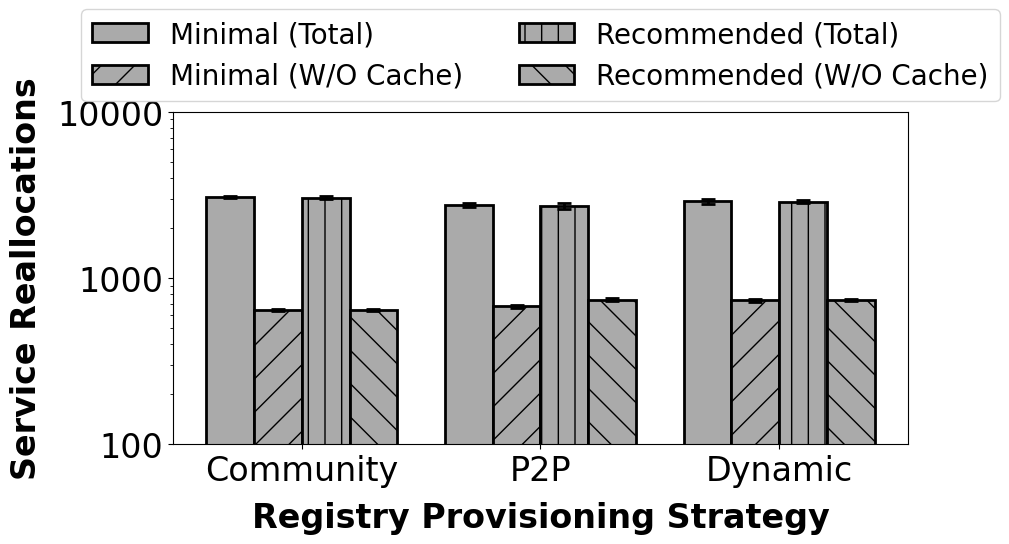

In [ ]:
plot_data_with_grouped_bar(
    [
        "minimal (total)",
        "minimal (w/o cache)",
        "recommended (total)",
        "recommended (w/o cache)",
    ],
    reallocations_mean_df_2,
    reallocations_std_df_2,
    "Registry Provisioning Strategy",
    "Service Reallocations",
    "logs/service_reallocations_grouped_2",
    (0.5, 1.35),
    "log",
    [100, 1000, 10000]
)

#### Registry Usage

In [ ]:
# Getting data transferred data
registry_usage_df_2 = get_registry_usage()

# Calculating mean values and standard deviations
registry_usage_mean_df_2 = registry_usage_df_2.groupby(["dataset"]).mean()
registry_usage_std_df_2 = registry_usage_df_2.groupby(["dataset"]).std()

In [ ]:
registry_usage_df_2

,seed,dataset,minimal,recommended
0,1,"(community, community)",0.225169,0.219430
1,1,"(p2p, p2p)",0.056671,0.084019
2,1,"(p2p_enhanced, p2p)",0.145365,0.171733
3,2,"(community, community)",0.220217,0.222438
4,2,"(p2p, p2p)",0.054483,0.085032
5,2,"(p2p_enhanced, p2p)",0.128685,0.159753
6,3,"(community, community)",0.222022,0.232482
7,3,"(p2p, p2p)",0.056842,0.084548
8,3,"(p2p_enhanced, p2p)",0.130460,0.192472
9,4,"(community, community)",0.222762,0.227529


In [ ]:
registry_usage_mean_df_2

,seed,minimal,recommended
dataset,,,
"(community, community)",3.0,0.224290,0.226567
"(p2p, p2p)",3.0,0.056201,0.083325
"(p2p_enhanced, p2p)",3.0,0.129445,0.164272


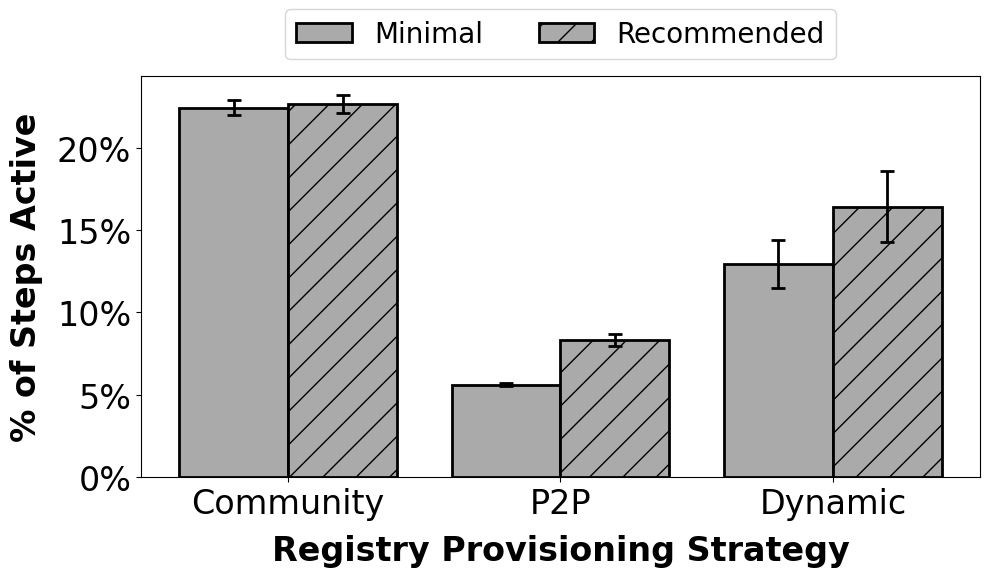

In [ ]:
plot_data_with_grouped_bar(
    ["minimal", "recommended"],
    registry_usage_mean_df_2,
    registry_usage_std_df_2,
    "Registry Provisioning Strategy",
    "% of Steps Active",
    "logs/registry_usage_grouped_2",
    (0.5, 1.2)
)

#### Number of Registries

In [ ]:
seed = 1
requirement = "minimal"

registry_df = get_number_of_registries(seed, requirement)

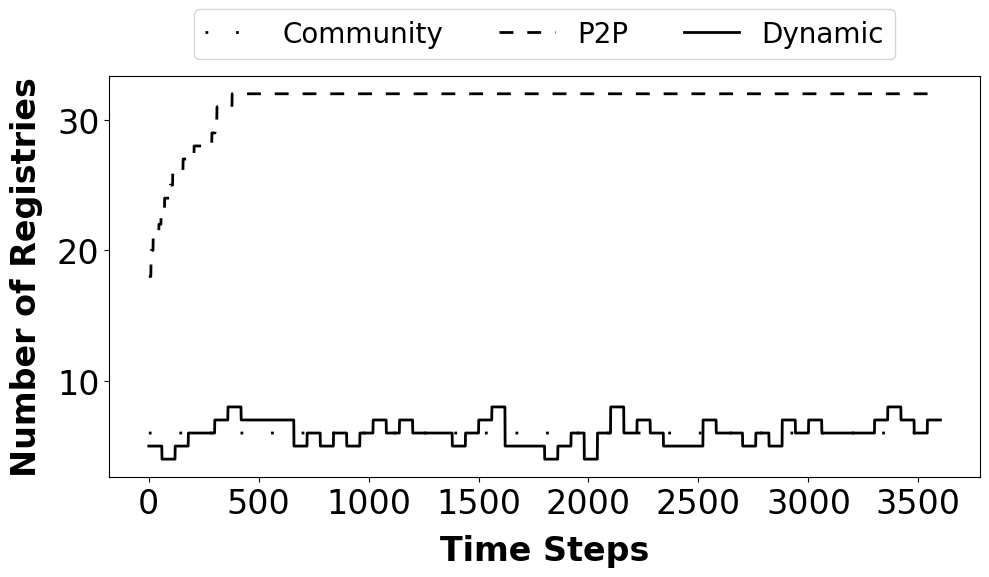

In [ ]:
plot_registries_over_time(
    labels,
    registry_df,
    "Time Steps",
    "Number of Registries",
    "logs/number_of_registries_over_time_2",
    (0.5, 1.2)
)